# SVM Model

In this section of the project, an SVM Model will be used to classify loan grades based on an individual personal information and details regarding his/her loan, such as loan intent and loan amount.

In [1]:
# import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, learning_curve, GridSearchCV, StratifiedShuffleSplit
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
import seaborn; seaborn.set()
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn import datasets, linear_model, preprocessing
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.io import arff
from sklearn.pipeline import Pipeline
from datetime import datetime
%matplotlib inline

In [2]:
# Load the dataset 
df = pd.read_excel('dataset.xlsx')

In [3]:
df

,Age,Income,Home_Ownership,Emp_Length,Loan_Intent,Loan Grade,Loan_Amnt,Loan_Int_Rate,Loan_Status,Loan_Percent_Income,Default_on_File,Credit_Hist_Length
0,22,59000,RENT,123,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5,PERSONAL,B,15000,11.48,0,0.10,N,26


In [4]:
dataset_description = df.describe()
mean_age = dataset_description.loc[['mean'], ['Age']]
mean_age

,Age
mean,27.7346


# Data Preprocessing

Remove empty data from the dataset and turn the categorical data into numerical data for the SVM model to process

In [5]:
# Remove the missing values. Row-wise parsing - removes rows that have NANs
df = df.replace('?', np.NaN)
df = df.dropna()

# Output the shape the dataset to make sure the size of the dataset decreased
df

,Age,Income,Home_Ownership,Emp_Length,Loan_Intent,Loan Grade,Loan_Amnt,Loan_Int_Rate,Loan_Status,Loan_Percent_Income,Default_on_File,Credit_Hist_Length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [6]:
df['Loan Grade'].unique()  # find all the unique values in the Loan Grade category, so we know how many values we need for the integer encoding step

array(['D', 'B', 'C', 'A', 'E', 'F', 'G'], dtype=object)

In [7]:
df['Loan_Intent'].unique()  # find all the unique values in the Loan Intent category, so we know how many values we need for the integer encoding step

array(['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT',
       'DEBTCONSOLIDATION'], dtype=object)

In [8]:
df['Home_Ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [9]:
# Replace the default_on_file data from Y/N to 1/0
df = df.replace('Y', 1)
df = df.replace('N', 0)

#Use integer encoding for the loan_grade data - since there is a natural ordered relationship
df = df.replace('A', 0)
df = df.replace('B', 1)
df = df.replace('C', 2)
df = df.replace('D', 3)
df = df.replace('E', 4)
df = df.replace('F', 5)
df = df.replace('G', 6)

# Use dummy encoding to convert the home ownership data and loan intent data

#Seperate the categorical data from the dataset
X_cat = df.loc[:,['Home_Ownership', 'Loan_Intent']]

# Apply dummy encoding on the categorical data
X_dummy = pd.get_dummies(data = X_cat, columns = X_cat.columns)

# Retrieve the binary data (Loan Status and Default on File), so we can combine all the categorical data into one matrix
X_bin = df_bin = df.loc[:,['Loan_Status', 'Default_on_File']]

# Combine all the cateogrical data into 1 matrix
X_cat_all = pd.concat([X_dummy,X_bin],axis=1)

In [10]:
# Print out X_cat_all, just to confirm that the cateogorical data was combined successfully
X_cat_all

,Home_Ownership_MORTGAGE,Home_Ownership_OTHER,Home_Ownership_OWN,Home_Ownership_RENT,Loan_Intent_DEBTCONSOLIDATION,Loan_Intent_EDUCATION,Loan_Intent_HOMEIMPROVEMENT,Loan_Intent_MEDICAL,Loan_Intent_PERSONAL,Loan_Intent_VENTURE,Loan_Status,Default_on_File
0,0,0,0,1,0,0,0,0,1,0,1,1
1,0,0,1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,1,0
3,0,0,0,1,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,1,0,0,0,0,0,0,0,1,0,0,0
32577,1,0,0,0,0,0,0,0,1,0,0,0
32578,0,0,0,1,0,0,1,0,0,0,1,0
32579,1,0,0,0,0,0,0,0,1,0,0,0


In [11]:
# Get the column names in the cateogorical data
list(X_cat_all.columns)

['Home_Ownership_MORTGAGE',
 'Home_Ownership_OTHER',
 'Home_Ownership_OWN',
 'Home_Ownership_RENT',
 'Loan_Intent_DEBTCONSOLIDATION',
 'Loan_Intent_EDUCATION',
 'Loan_Intent_HOMEIMPROVEMENT',
 'Loan_Intent_MEDICAL',
 'Loan_Intent_PERSONAL',
 'Loan_Intent_VENTURE',
 'Loan_Status',
 'Default_on_File']

In [12]:
df.shape
# df.columns

(28638, 12)

In [13]:
# Combine all the predictors (numerical and categorical data into one matrix)
X_num = df.loc[:,['Age', 'Income', 'Emp_Length', 'Loan_Amnt', 'Loan_Int_Rate', 'Loan_Percent_Income', 'Credit_Hist_Length']]
X =  pd.concat([X_num,X_cat_all],axis=1)

# Seperate the expected outcome column (loan_grade) from the dataset
y = df.loc[:,['Loan Grade']]

In [14]:
# Confirm that the predictor data combined successfully
X

,Age,Income,Emp_Length,Loan_Amnt,Loan_Int_Rate,Loan_Percent_Income,Credit_Hist_Length,Home_Ownership_MORTGAGE,Home_Ownership_OTHER,Home_Ownership_OWN,Home_Ownership_RENT,Loan_Intent_DEBTCONSOLIDATION,Loan_Intent_EDUCATION,Loan_Intent_HOMEIMPROVEMENT,Loan_Intent_MEDICAL,Loan_Intent_PERSONAL,Loan_Intent_VENTURE,Loan_Status,Default_on_File
0,22,59000,123.0,35000,16.02,0.59,3,0,0,0,1,0,0,0,0,1,0,1,1
1,21,9600,5.0,1000,11.14,0.10,2,0,0,1,0,0,1,0,0,0,0,0,0
2,25,9600,1.0,5500,12.87,0.57,3,1,0,0,0,0,0,0,1,0,0,1,0
3,23,65500,4.0,35000,15.23,0.53,2,0,0,0,1,0,0,0,1,0,0,1,0
4,24,54400,8.0,35000,14.27,0.55,4,0,0,0,1,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0.11,30,1,0,0,0,0,0,0,0,1,0,0,0
32577,54,120000,4.0,17625,7.49,0.15,19,1,0,0,0,0,0,0,0,1,0,0,0
32578,65,76000,3.0,35000,10.99,0.46,28,0,0,0,1,0,0,1,0,0,0,1,0
32579,56,150000,5.0,15000,11.48,0.10,26,1,0,0,0,0,0,0,0,1,0,0,0


In [15]:
# Confirm that the expected outcome data combined successfully
y

,Loan Grade
0,3
1,1
2,2
3,2
4,2
...,...
32576,2
32577,0
32578,1
32579,1


Now that the NaNs and categorical data have been handled. 
1. The data needs to be split into training, validation, and testing sets. 
2. The training and testing sets need to be scaled 

In [16]:
# Split the dataset into training/validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.07, random_state=10, shuffle=True)

# Split the training_validation data into two seperate sets for the training of the model - to get the initial weights - and then validation for optimization
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.07, random_state=10, shuffle=True)


In [17]:
# Check to make sure everything is as expected
print('X_train:' + str(X_train.shape))
print('y_train:' + str(y_train.shape))
print('X_val: \t'  + str(X_val.shape))
print('y_val: \t'  + str(y_val.shape))
print('X_test: '  + str(X_test.shape))
print('y_test: '  + str(y_test.shape))

X_train:(24768, 19)
y_train:(24768, 1)
X_val: 	(1865, 19)
y_val: 	(1865, 1)
X_test: (2005, 19)
y_test: (2005, 1)


In [18]:
# Normalize the features with numerical data (not the categorical features from before) in the training, validation, and testing predictor datasets
# Will allow us to do PCA in the next step

# Copy the data
training_num_data = X_train.loc[:,['Age', 'Income', 'Emp_Length', 'Loan_Amnt', 'Loan_Int_Rate', 'Loan_Percent_Income', 'Credit_Hist_Length']]
X_train_scaled = training_num_data.copy()
X_train_scaled_cols = X_train_scaled.columns

validation_num_data = X_val.loc[:,['Age', 'Income', 'Emp_Length', 'Loan_Amnt', 'Loan_Int_Rate', 'Loan_Percent_Income', 'Credit_Hist_Length']]
X_val_scaled = validation_num_data.copy()
X_val_scaled_cols = X_val_scaled.columns

testing_num_data = X_test.loc[:,['Age', 'Income', 'Emp_Length', 'Loan_Amnt', 'Loan_Int_Rate', 'Loan_Percent_Income', 'Credit_Hist_Length']]
X_test_scaled = testing_num_data.copy()
X_test_scaled_cols = X_test_scaled.columns

# Apply Z-score normalization technique

# Method 1: from https://www.geeksforgeeks.org/data-normalization-with-pandas/
# for col in X_train_scaled.columns:
#     X_train_scaled[col] = (X_train_scaled[col] - X_train_scaled[col].mean()) / (X_train_scaled[col].std())
    
# for col in X_val_scaled.columns:
#     X_val_scaled[col] = (X_val_scaled[col] - X_val_scaled[col].mean()) / (X_val_scaled[col].std())
    
# for col in X_test_scaled.columns:
#     X_test_scaled[col] = (X_test_scaled[col] - X_test_scaled[col].mean()) / (X_test_scaled[col].std())
    

# Method 2: from https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
X_train_scaled = StandardScaler().fit_transform(X_train_scaled)
X_val_scaled = StandardScaler().fit_transform(X_val_scaled)
X_test_scaled = StandardScaler().fit_transform(X_test_scaled)


In [19]:
# Convert the numPy arrays to pandas dataframes 
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train_scaled_cols

X_val_scaled = pd.DataFrame(X_val_scaled)
X_val_scaled.columns = X_val_scaled_cols

X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X_test_scaled_cols

In [20]:
X_train_scaled

,Age,Income,Emp_Length,Loan_Amnt,Loan_Int_Rate,Loan_Percent_Income,Credit_Hist_Length
0,0.043791,-0.437643,0.294899,0.681202,-0.970833,1.789327,0.547993
1,0.361906,0.097792,-0.185221,0.365821,1.002382,-0.090209,-0.196301
2,-0.910555,-0.749456,0.294899,-1.305702,1.204047,-0.936000,-0.444399
3,-0.433382,-0.576226,1.015079,0.838893,-0.257249,3.105002,-0.940595
4,-0.274324,-0.371501,1.495199,-0.580324,0.571129,-0.278163,-0.692497
...,...,...,...,...,...,...,...
24763,-0.433382,0.034800,-0.905400,-0.264943,0.918614,-0.466116,-0.940595
24764,0.520964,0.747197,2.455438,1.233120,1.145099,-0.184186,0.051797
24765,0.202849,-0.705424,0.294899,-0.186097,0.955844,2.071257,0.299895
24766,-0.592440,1.467877,1.015079,0.365821,1.781120,-0.936000,-0.444399


In [21]:
X_val_scaled

,Age,Income,Emp_Length,Loan_Amnt,Loan_Int_Rate,Loan_Percent_Income,Credit_Hist_Length
0,-1.086299,-0.725947,-1.195161,-0.722886,0.530188,0.942939,-0.695413
1,2.137423,-0.314384,0.022459,-0.788741,-0.055442,-0.636597,2.535147
2,0.364376,-0.063665,0.753031,0.923497,-1.293456,0.664197,1.044119
3,-0.441555,-0.408290,0.996555,-0.722886,-0.695689,-0.357855,-0.695413
4,0.525562,0.846807,2.457700,1.582050,0.697077,-0.172028,0.795615
...,...,...,...,...,...,...,...
1860,0.203190,-0.372172,0.996555,-0.146652,-0.067579,0.292542,0.050101
1861,0.525562,0.139498,0.996555,0.429582,1.452630,-0.079114,-0.198404
1862,2.459795,0.199694,0.022459,0.100306,0.096276,-0.357855,1.541129
1863,-1.086299,-0.444408,-0.951637,-0.393609,-0.055442,0.199628,-0.695413


In [22]:
training_cat_data = X_train.loc[:,['Home_Ownership_MORTGAGE','Home_Ownership_OTHER','Home_Ownership_OWN','Home_Ownership_RENT','Loan_Intent_DEBTCONSOLIDATION','Loan_Intent_EDUCATION','Loan_Intent_HOMEIMPROVEMENT','Loan_Intent_MEDICAL','Loan_Intent_PERSONAL','Loan_Intent_VENTURE','Loan_Status','Default_on_File']]
training_cat_data

,Home_Ownership_MORTGAGE,Home_Ownership_OTHER,Home_Ownership_OWN,Home_Ownership_RENT,Loan_Intent_DEBTCONSOLIDATION,Loan_Intent_EDUCATION,Loan_Intent_HOMEIMPROVEMENT,Loan_Intent_MEDICAL,Loan_Intent_PERSONAL,Loan_Intent_VENTURE,Loan_Status,Default_on_File
26146,0,0,0,1,0,1,0,0,0,0,1,0
25586,0,0,0,1,0,0,0,0,0,1,1,1
544,1,0,0,0,0,0,1,0,0,0,1,1
2180,1,0,0,0,0,0,1,0,0,0,0,0
5054,1,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9429,0,0,0,1,0,0,1,0,0,0,1,1
18633,0,0,0,1,0,0,1,0,0,0,0,1
20995,0,0,0,1,1,0,0,0,0,0,1,1
373,1,0,0,0,0,0,0,0,0,1,0,0


In [23]:
validation_cat_data = X_val.loc[:,['Home_Ownership_MORTGAGE','Home_Ownership_OTHER','Home_Ownership_OWN','Home_Ownership_RENT','Loan_Intent_DEBTCONSOLIDATION','Loan_Intent_EDUCATION','Loan_Intent_HOMEIMPROVEMENT','Loan_Intent_MEDICAL','Loan_Intent_PERSONAL','Loan_Intent_VENTURE','Loan_Status','Default_on_File']]
validation_cat_data

,Home_Ownership_MORTGAGE,Home_Ownership_OTHER,Home_Ownership_OWN,Home_Ownership_RENT,Loan_Intent_DEBTCONSOLIDATION,Loan_Intent_EDUCATION,Loan_Intent_HOMEIMPROVEMENT,Loan_Intent_MEDICAL,Loan_Intent_PERSONAL,Loan_Intent_VENTURE,Loan_Status,Default_on_File
9185,0,0,0,1,0,1,0,0,0,0,1,1
29876,0,0,0,1,0,0,0,0,1,0,0,0
23438,1,0,0,0,0,0,0,1,0,0,0,0
3953,1,0,0,0,0,0,0,0,1,0,0,0
27112,1,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20716,1,0,0,0,0,1,0,0,0,0,0,0
25626,1,0,0,0,0,1,0,0,0,0,1,0
31086,0,0,0,1,0,0,1,0,0,0,0,0
7787,0,0,0,1,1,0,0,0,0,0,0,0


In [24]:
X_train

,Age,Income,Emp_Length,Loan_Amnt,Loan_Int_Rate,Loan_Percent_Income,Credit_Hist_Length,Home_Ownership_MORTGAGE,Home_Ownership_OTHER,Home_Ownership_OWN,Home_Ownership_RENT,Loan_Intent_DEBTCONSOLIDATION,Loan_Intent_EDUCATION,Loan_Intent_HOMEIMPROVEMENT,Loan_Intent_MEDICAL,Loan_Intent_PERSONAL,Loan_Intent_VENTURE,Loan_Status,Default_on_File
26146,28,39000,6.0,14000,7.90,0.36,8,0,0,0,1,0,1,0,0,0,0,1,0
25586,30,73000,4.0,12000,14.26,0.16,5,0,0,0,1,0,0,0,0,0,1,1,1
544,22,19200,6.0,1400,14.91,0.07,4,1,0,0,0,0,0,1,0,0,0,1,1
2180,25,30200,9.0,15000,10.20,0.50,2,1,0,0,0,0,0,1,0,0,0,0,0
5054,26,43200,11.0,6000,12.87,0.14,3,1,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9429,25,69000,1.0,8000,13.99,0.12,2,0,0,0,1,0,0,1,0,0,0,1,1
18633,31,114237,15.0,17500,14.72,0.15,6,0,0,0,1,0,0,1,0,0,0,0,1
20995,29,21996,6.0,8500,14.11,0.39,7,0,0,0,1,1,0,0,0,0,0,1,1
373,24,160000,9.0,12000,16.77,0.07,4,1,0,0,0,0,0,0,0,0,1,0,0


In [25]:
# Concatenate the scaled data with the cateogorical data for each dataset

# Reset the indexes to fix the NaN issue when concatenating the numerical data with the categorical data
X_train_scaled.reset_index(drop=True, inplace=True)
training_cat_data.reset_index(drop=True, inplace=True)
X_train_all = pd.concat([X_train_scaled,training_cat_data],axis=1)

validation_cat_data = X_val.loc[:,['Home_Ownership_MORTGAGE','Home_Ownership_OTHER','Home_Ownership_OWN','Home_Ownership_RENT','Loan_Intent_DEBTCONSOLIDATION','Loan_Intent_EDUCATION','Loan_Intent_HOMEIMPROVEMENT','Loan_Intent_MEDICAL','Loan_Intent_PERSONAL','Loan_Intent_VENTURE','Loan_Status','Default_on_File']]
X_val_scaled.reset_index(drop=True, inplace=True)
validation_cat_data.reset_index(drop=True, inplace=True)
X_val_all =  pd.concat([X_val_scaled,validation_cat_data],axis=1)

testing_cat_data = X_test.loc[:,['Home_Ownership_MORTGAGE','Home_Ownership_OTHER','Home_Ownership_OWN','Home_Ownership_RENT','Loan_Intent_DEBTCONSOLIDATION','Loan_Intent_EDUCATION','Loan_Intent_HOMEIMPROVEMENT','Loan_Intent_MEDICAL','Loan_Intent_PERSONAL','Loan_Intent_VENTURE','Loan_Status','Default_on_File']]
X_test_scaled.reset_index(drop=True, inplace=True)
testing_cat_data.reset_index(drop=True, inplace=True)
X_test_all =  pd.concat([X_test_scaled,testing_cat_data],axis=1)


In [45]:
X_train_all.shape

(24768, 19)

In [26]:
# Reshape the size of y_train, y_val, and y_test to avoid a Data Conversion Warning
# y_train = column_or_1d(y_train, warn=True)
# y_val = column_or_1d(y_val, warn=True)
# y_test = column_or_1d(y_test, warn=True)
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_val = np.reshape(y_val, (y_val.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))


#y = column_or_1d(y, warn=True) - suggestion I got from warning message

# Test Model Parameters using Cross-Validaiton Method

Objective: Try different parameter values for each SVM model (linear, polynomial, and RBF) and calculate/plot the training and generaiton error. The paramter values that generate the lowest generalization error will be selected for the final model for the loan grade prediction. 

Notes based on the reading from this source, https://queirozf.com/entries/choosing-c-hyperparameter-for-svm-classifiers-examples-with-scikit-learn, 

1. The choice of C for a linear kernal does not affect the performance as much. However, we will still test out C values here to get the best performance from the model. 
2. For a polynomial kernal, C affects E_out and the best value for C is not always the lowest C value.
3. For radial-based function kernal, a lower C value helps the model adapt to noisy data.

Notes for Radial-Based Kernal Function:
1. For this kernal function, we will also test out different gamma values. The gamma value will indicate how much influence a single training example has on the margin. 
2. The validation set will be used to test the gamma values and C values to get the best balance between the two.

Note for Polynomial-Based Kernal Function:
1. Along with testing out different C-values, we will test out different degrees for the polynomial kernal function.

**Going to test combination of parameter values using GridSearchCV. Function below will model technique found in https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee**

**One vs One multiclass classification will be used in all three models during this section. The decision_function_shape parameter will be set to 'ovo' in each SVC object created.**

In [ ]:
c_range = np.logspace(-2, 10, 15)
gamma_range = np.logspace(-9, 3, 15)
param_grid = dict(gamma=gamma_range, C=c_range)
cv = StratifiedShuffleSplit(n_splits = 5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train_all, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

In [50]:
# Create a function that graphs the training and validation accuracy scores with respect to the parameter values we are testing
def plot_accuracy_scores(train_acc_scores, val_acc_scores, cVals, dVals, gVals, modelType):
    if modelType == "Linear":
        plt.plot(cVals, train_acc_scores, 'b')
        plt.plot(cVals, val_acc_scores, 'r')
        plt.xlabel("C Value")
        plt.ylabel("Model Accuracy")
        plt.ylim(0.55, 0.9)
        plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
    elif modelType == "Polynomial":
        fig, ax = plt.subplots(2, 2)
        
        X_poly_tr = np.array([[0.351784561, 0.736393734, 0.859940245, 0.893370478, 0.899628553, 0.902575904]
                             ,[0.363129845, 0.683825904, 0.850613695, 0.896721576, 0.916545543, 0.926800711]
                             ,[0.363129845, 0.558381783, 0.803900194, 0.893007106, 0.930071059, 0.953044251]
                             ,[0.360505491, 0.549135982, 0.742409561, 0.87879522, 0.934875646, 0.967377261]])
        
        X_poly_val = np.array([[0.337801609, 0.717426273, 0.833243968, 0.862198391, 0.872386059, 0.871313673]
                              ,[0.350134048, 0.663270777, 0.818766756, 0.859517426, 0.860053619, 0.859517426]
                              ,[0.331903485, 0.543699732, 0.768364611, 0.845040214, 0.850402145, 0.835924933]
                              ,[0.343699732, 0.531367292, 0.71849866, 0.812868633, 0.835924933, 0.831635389]])
        
        #Plotting Degree 2
        ax[0,0].plot(X_poly_tr[0,:], X_poly_val[0,:])
        axis[0,0].set_title("Polynomial Model (Degree = 2)")
        
        #Plotting Degree 3
        ax[0,1].plot(X_poly_tr[1,:], X_poly_val[1,:])
        axis[0,1].set_title("Polynomial Model (Degree = 3)")
        
        #Plotting Degree 4
        ax[1,0].plot(X_poly_tr[2,:], X_poly_val[2,:])
        axis[1,0].set_title("Polynomial Model (Degree = 4)")
        
        #Plotting Degree 5
        ax[1,1].plot(X_poly_tr[3,:], X_poly_val[3,:])
        axis[1,1].set_title("Polynomial Model (Degree = 5)")
        
        plt.show()
        
        
        
#     elif modelType == "Radial Based Function":
        
        
        
# # Initialise the subplot function using number of rows and columns
# figure, axis = plt.subplots(2, 2)
  
# # For Sine Function
# axis[0, 0].plot(X, Y1)
# axis[0, 0].set_title("Sine Function")
  
# # For Cosine Function
# axis[0, 1].plot(X, Y2)
# axis[0, 1].set_title("Cosine Function")
  
# # For Tangent Function
# axis[1, 0].plot(X, Y3)
# axis[1, 0].set_title("Tangent Function")
  
# # For Tanh Function
# axis[1, 1].plot(X, Y4)
# axis[1, 1].set_title("Tanh Function")
  
# # Combine all the operations and display
# plt.show()
    

In [52]:
# Create a function that takes in a training and validation set and outputs the training and validation accuracy of the pre
def test_param_vals(X_train, X_val, y_train, y_val, modelType="Linear"):
    # Initialize a list that keeps track of the following:
    # 1. training accuracy for each C value
    # 2. validation accuract for each C value
    # 3. list of different C values to test
    train_acc_lin = []
    val_acc_lin = []
    
    train_acc_poly = []
    val_acc_poly = []
    
    train_acc_rbf = []
    val_acc_rbf = []
    
    optimalParams = []
    c_values = [0.001, 0.01, 0.1, 1.0 ,10.0, 100.0]
    # degree_values = [1, 2, 3, 4, 5, 10, 15] - going to eliminate 10 and 15, as the code takes too long to run and their training/accuracy scores are low
    degree_values = [2, 3, 4, 5]
    gamma_values = [0.1, 1, 10]  # values based on example from https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
    
    # Also keep track of the max val accuracy score and the c value associated with the max val
    max_val_score, max_c_value, max_d_val, max_g_val = -1, c_values[0], degree_values[0], gamma_values[0]
    
    
    # Traverse through each c-value 
    for c in c_values:
        print("C = ", c)
        
        if modelType == "Linear":
            # Create an SVM classifier with a linear kernal function with the given C value and fit the training data to the model
            testing_model = SVC(kernel='linear', decision_function_shape='ovo', C=c)
            testing_model.fit(X_train, y_train)
            
            # Predict and calculate the training accuracy
            y_hat_train = testing_model.predict(X_train)
            train_acc_score = accuracy_score(y_train, y_hat_train)
            train_acc_lin.append(train_acc_score)
            print("Training Accuracy Score = ", train_acc_score)


            # Predict and calculate the validation accuracy
            y_hat_val = testing_model.predict(X_val)
            val_acc_score = accuracy_score(y_val, y_hat_val)
            val_acc_lin.append(val_acc_score)
            print("Validation Accuracy Score = ", val_acc_score)


            # Keep track of the C value that yields the highest validation accuracy score
            if(val_acc_score > max_val_score):
                max_val_score = val_acc_score
                max_c_value = c
                
            print()
                
        elif modelType == "Polynomial":
            for d in degree_values:
                print("D = ", d)
                # Create an SVM classifier with a given polynomial function with the given C value and fit the training data to the model
                testing_model = SVC(kernel='poly', degree=d, decision_function_shape='ovo', C=c)
                testing_model.fit(X_train, y_train)
            
                # Predict and calculate the training accuracy
                y_hat_train = testing_model.predict(X_train)
                train_acc_score = accuracy_score(y_train, y_hat_train)
                train_acc_poly.append(train_acc_score)
                print("Training Accuracy Score = ", train_acc_score)


                # Predict and calculate the validation accuracy
                y_hat_val = testing_model.predict(X_val)
                val_acc_score = accuracy_score(y_val, y_hat_val)
                val_acc_poly.append(val_acc_score)
                print("Validation Accuracy Score = ", val_acc_score)


                # Keep track of the C value that yields the highest validation accuracy score
                if(val_acc_score > max_val_score):
                    max_val_score = val_acc_score
                    max_c_value = c
                    max_d_value = d
                    
                print()
        
        elif modelType == "Radial Based Function":
            for g in gamma_values:
                print("G = ", g)
               # Create an SVM classifier with a radial based kernal function with the given C value and fit the training data to the model
                testing_model = SVC(kernel='rbf', gamma=g, decision_function_shape='ovo', C=c)
                testing_model.fit(X_train, y_train)
            
                # Predict and calculate the training accuracy
                y_hat_train = testing_model.predict(X_train)
                train_acc_score = accuracy_score(y_train, y_hat_train)
                train_acc_rbf.append(train_acc_score)
                print("Training Accuracy Score = ", train_acc_score)


                # Predict and calculate the validation accuracy
                y_hat_val = testing_model.predict(X_val)
                val_acc_score = accuracy_score(y_val, y_hat_val)
                val_acc_rbf.append(val_acc_score)
                print("Validation Accuracy Score = ", val_acc_score)


                # Keep track of the C value that yields the highest validation accuracy score
                if(val_acc_score > max_val_score):
                    max_val_score = val_acc_score
                    max_c_value = c
                    max_g_value = g
                    
                print()
            
    if modelType == "Linear":
        optimalParams.append(max_val_score)
        optimalParams.append(max_c_value)
        # plot_accuracy_scores(train_acc_lin, val_acc_lin, c_values, degree_values, gamma_values, modelType)
    elif modelType == "Polynomial":
        optimalParams.append(max_val_score)
        optimalParams.append(max_c_value)
        optimalParams.append(max_d_value)
        # plot_accuracy_scores(train_acc_poly, val_acc_poly, c_values, degree_values, gamma_values, modelType)
    elif modelType == "Radial Based Function":
        optimalParams.append(max_val_score)
        optimalParams.append(max_c_value)
        optimalParams.append(max_g_value)
        # plot_accuracy_scores(train_acc_rbf, val_acc_rbf, c_values, degree_values, gamma_values, modelType)
            
        
    return optimalParams
                     
                
        
            
            
        
        
        

In [28]:
# Part 1a: Test out different C values for the linear kernal model
print("Linear Model")
optimalParams = test_param_vals(X_train_all, X_val_all, y_train, y_val, "Linear")
max_val_acc_lin, max_c_value_lin,  = optimalParams[0], optimalParams[1]
print()
print("Maximum Validation Accuracy = ", max_val_acc_lin)
print("Optimal C Value for Linear Model = ", max_c_value_lin)
print()


Linear Model
C =  0.001


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.836765180878553
Validation Accuracy Score =  0.8005361930294906

C =  0.01


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.8805717054263565
Validation Accuracy Score =  0.8546916890080429

C =  0.1


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.8892118863049095
Validation Accuracy Score =  0.8723860589812332

C =  1.0


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.8888888888888888
Validation Accuracy Score =  0.8729222520107238

C =  10.0


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.8850532945736435
Validation Accuracy Score =  0.8729222520107238

C =  100.0


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.8848514211886305
Validation Accuracy Score =  0.8739946380697051


Maximum Validation Accuracy =  0.8739946380697051
Optimal C Value for Linear Model =  100.0



In [37]:
# Part 2: Test out different C values for the polynomial kernal model along with degree for the model.
print("Polynomial Model")
optimalParams = test_param_vals(X_train_all, X_val_all, y_train, y_val, "Polynomial")
max_val_acc_poly, max_c_value_poly, max_d_value_poly = optimalParams[0], optimalParams[1], optimalParams[2] 
print()
print("Maximum Validation Accuracy = ", max_val_acc_poly)
print("Optimal C Value for Polynomial Model = ", max_c_value_poly)
print("Optimal Degree for Polynomial Model = ", max_d_value_poly)
print()

Polynomial Model
C =  0.001
D =  2


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.3517845607235142
Validation Accuracy Score =  0.3378016085790885

D =  3


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.3631298449612403
Validation Accuracy Score =  0.35013404825737265

D =  4


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.3468184754521964
Validation Accuracy Score =  0.3319034852546917

D =  5


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.36050549095607237
Validation Accuracy Score =  0.34369973190348524

C =  0.01
D =  2


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.7363937338501292
Validation Accuracy Score =  0.717426273458445

D =  3


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.6838259043927648
Validation Accuracy Score =  0.6632707774798927

D =  4


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.5583817829457365
Validation Accuracy Score =  0.5436997319034853

D =  5


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.5491359819121447
Validation Accuracy Score =  0.5313672922252011

C =  0.1
D =  2


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.8599402454780362
Validation Accuracy Score =  0.8332439678284183

D =  3


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.8506136950904393
Validation Accuracy Score =  0.8187667560321715

D =  4


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.8039001937984496
Validation Accuracy Score =  0.7683646112600536

D =  5


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.7424095607235142
Validation Accuracy Score =  0.7184986595174263

C =  1.0
D =  2


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.8933704780361758
Validation Accuracy Score =  0.8621983914209115

D =  3


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.8967215762273901
Validation Accuracy Score =  0.8595174262734584

D =  4


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.8930071059431525
Validation Accuracy Score =  0.8450402144772118

D =  5


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.8787952196382429
Validation Accuracy Score =  0.8128686327077748

C =  10.0
D =  2


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.8996285529715762
Validation Accuracy Score =  0.8723860589812332

D =  3


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.9165455426356589
Validation Accuracy Score =  0.8600536193029491

D =  4


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.9300710594315246
Validation Accuracy Score =  0.850402144772118

D =  5


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.9348756459948321
Validation Accuracy Score =  0.8359249329758713

C =  100.0
D =  2


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.9025759043927648
Validation Accuracy Score =  0.871313672922252

D =  3


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.9268007105943152
Validation Accuracy Score =  0.8595174262734584

D =  4


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.9530442506459949
Validation Accuracy Score =  0.8359249329758713

D =  5


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.9673772609819121
Validation Accuracy Score =  0.8316353887399464


Maximum Validation Accuracy =  0.8723860589812332
Optimal C Value for Polynomial Model =  10.0
Optimal Degree for Polynomial Model =  2



In [34]:
# Part 3: Test out different C values for the rbf kernal model along with gamma values for the model.
print("Radial Based Function Model")
optimalParams = test_param_vals(X_train_all, X_val_all, y_train, y_val, "Radial Based Function")
max_val_acc_rbf, max_c_value_rbf, max_g_value = optimalParams[0], optimalParams[1], optimalParams[2]
print()
print("Maximum Validation Accuracy = ", max_val_acc_rbf)
print("Optimal C Value for RBF Model = ", max_c_value_rbf)
print("Optimal Gamma Value for RBF Model = ", max_g_value)

Radial Based Function Model
C =  0.001
G =  0.1


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.5815164728682171
Validation Accuracy Score =  0.5463806970509384

G =  1


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.32893249354005166
Validation Accuracy Score =  0.31742627345844504

G =  10


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.32893249354005166
Validation Accuracy Score =  0.31742627345844504

C =  0.01
G =  0.1


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.7718830749354005
Validation Accuracy Score =  0.7469168900804289

G =  1


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.5901970284237726
Validation Accuracy Score =  0.5522788203753352

G =  10


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.32893249354005166
Validation Accuracy Score =  0.31742627345844504

C =  0.1
G =  0.1


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.8717296511627907
Validation Accuracy Score =  0.8428954423592493

G =  1


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.7399467054263565
Validation Accuracy Score =  0.685254691689008

G =  10


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.32893249354005166
Validation Accuracy Score =  0.31742627345844504

C =  1.0
G =  0.1


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.9004764211886305
Validation Accuracy Score =  0.8691689008042895

G =  1


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.961765180878553
Validation Accuracy Score =  0.8187667560321715

G =  10


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.9992732558139535
Validation Accuracy Score =  0.5297587131367292

C =  10.0
G =  0.1


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.9244589793281653
Validation Accuracy Score =  0.871313672922252

G =  1


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.9945897932816538
Validation Accuracy Score =  0.7983914209115281

G =  10


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  1.0
Validation Accuracy Score =  0.5431635388739946

C =  100.0
G =  0.1


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.9518330103359173
Validation Accuracy Score =  0.8498659517426274

G =  1


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  0.9996770025839793
Validation Accuracy Score =  0.7946380697050939

G =  10


C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Score =  1.0
Validation Accuracy Score =  0.5431635388739946


Maximum Validation Accuracy =  0.871313672922252
Optimal C Value for RBF Model =  10.0
Optimal Gamma Value for RBF Model =  0.1


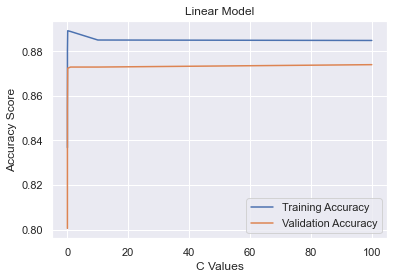

In [67]:
# Plot the linear model training and validation accuracy scores
X_lin_tr = np.array([[0.836765180878553, 0.8805717054263565, 0.8892118863049095, 0.8888888888888888, 0.8850532945736435, 0.8848514211886305]])
X_lin_val = np.array([[0.8005361930294906, 0.8546916890080429, 0.8723860589812332, 0.8729222520107238, 0.8729222520107238, 0.8739946380697051]])

c_values = [0.001, 0.01, 0.1, 1.0 ,10.0, 100.0]

plt.plot(c_values, X_lin_tr[0])
plt.plot(c_values, X_lin_val[0])

plt.xlabel('C Values')
plt.ylabel('Accuracy Score')
plt.title('Linear Model')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')

plt.show()

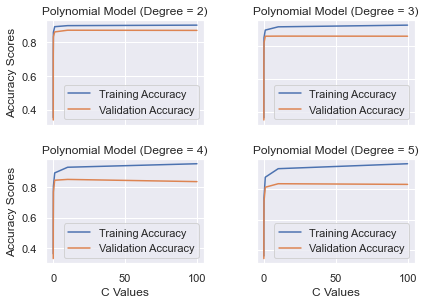

In [69]:
# Plot the polynomial training and validation accuracy scores
fig, ax = plt.subplots(2, 2)
        
    
c_values = [0.001, 0.01, 0.1, 1.0 ,10.0, 100.0]

X_poly_tr = np.array([[0.351784561, 0.736393734, 0.859940245, 0.893370478, 0.899628553, 0.902575904]
                             ,[0.363129845, 0.683825904, 0.850613695, 0.896721576, 0.916545543, 0.926800711]
                             ,[0.363129845, 0.558381783, 0.803900194, 0.893007106, 0.930071059, 0.953044251]
                             ,[0.360505491, 0.549135982, 0.742409561, 0.87879522, 0.934875646, 0.967377261]])
        
X_poly_val = np.array([[0.337801609, 0.717426273, 0.833243968, 0.862198391, 0.872386059, 0.871313673]
                              ,[0.350134048, 0.663270777, 0.818766756, 0.859517426, 0.860053619, 0.859517426]
                              ,[0.331903485, 0.543699732, 0.768364611, 0.845040214, 0.850402145, 0.835924933]
                              ,[0.343699732, 0.531367292, 0.71849866, 0.812868633, 0.835924933, 0.831635389]])
        
# Set the spacing of the figure - pad = 5.0
fig.tight_layout()
#plt.figure(figsize=(10,10))
    
#Plotting Degree 2
ax[0,0].plot(c_values, X_poly_tr[0,:])
ax[0,0].plot(c_values, X_poly_val[0,:])
ax[0,0].set_title("Polynomial Model (Degree = 2)")

#Plotting Degree 3
ax[0,1].plot(c_values, X_poly_tr[1,:])
ax[0,1].plot(c_values, X_poly_val[1,:])
ax[0,1].set_title("Polynomial Model (Degree = 3)")

#Plotting Degree 4
ax[1,0].plot(c_values, X_poly_tr[2,:])
ax[1,0].plot(c_values, X_poly_val[2,:])
ax[1,0].set_title("Polynomial Model (Degree = 4)")

#Plotting Degree 5
ax[1,1].plot(c_values, X_poly_tr[3,:])
ax[1,1].plot(c_values, X_poly_val[3,:])
ax[1,1].set_title("Polynomial Model (Degree = 5)")

# Set the y and x labels
for axis in ax.flat:
    axis.set(xlabel='C Values', ylabel='Accuracy Scores')
    axis.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')

for axis in ax.flat:
    axis.label_outer()

plt.show()

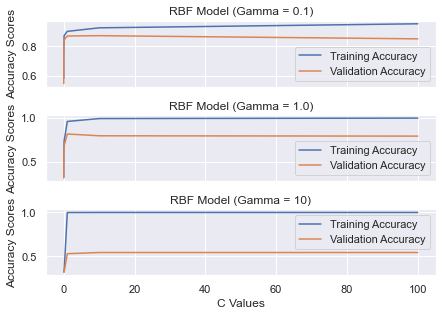

In [74]:
# Plot the RBF training and validation accuracy scores
fig, ax = plt.subplots(3, 1)
        
    
c_values = [0.001, 0.01, 0.1, 1.0 ,10.0, 100.0]
        
X_rbf_tr = np.array([[0.581516473, 0.74691689, 0.871729651, 0.900476421, 0.924458979, 0.95183301]
                    ,[0.328932494, 0.590197028, 0.739946705, 0.961765181, 0.994589793, 0.999677003]
                    ,[0.328932494, 0.328932494, 0.328932494, 0.999273256, 1, 1]])
    
X_rbf_val = np.array([[0.546380697, 0.771883075, 0.842895442, 0.869168901, 0.871313673, 0.849865952]
                      ,[0.317426273, 0.55227882, 0.685254692, 0.818766756, 0.798391421, 0.79463807]
                      ,[0.317426273, 0.317426273, 0.317426273, 0.529758713, 0.543163539, 0.543163539]])

        
# Set the spacing of the figure - pad = 5.0
fig.tight_layout(pad=0.5)
#plt.figure(figsize=(10,10))
    
#Plotting Gamma = 0.1
ax[0].plot(c_values, X_rbf_tr[0,:])
ax[0].plot(c_values, X_rbf_val[0,:])
ax[0].set_title("RBF Model (Gamma = 0.1)")

#Plotting Gamma = 1.0
ax[1].plot(c_values, X_rbf_tr[1,:])
ax[1].plot(c_values, X_rbf_val[1,:])
ax[1].set_title("RBF Model (Gamma = 1.0)")

#Plotting Gamma = 10
ax[2].plot(c_values, X_rbf_tr[2,:])
ax[2].plot(c_values, X_rbf_val[2,:])
ax[2].set_title("RBF Model (Gamma = 10)")

# Set the y and x labels
for axis in ax.flat:
    axis.set(xlabel='C Values', ylabel='Accuracy Scores')
    axis.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')

for axis in ax.flat:
    axis.label_outer()

plt.show()

# Create SVM Model for Multiclass Classification

Create an SVM model for the loan grade prediction. A model is being created prior to the PCA step to see if PCA actually will help create better predictions for loan grade (A-G). We will have three models in this section, each with a different kernal function. For this project, we will investigate models with a linear, polynomial (degree = 3), and radial basis function kernal. 

The one-versus-one approach will be used for multiclass classification 

The train, validation errors will be calculated and graphed to visually demonstrate which kernal function will be optimal in predicting loan grade from the 19 features. 

The test error and accuracy of the model will be calculated to show how the model predicts new data

In [38]:
# Create the model setting the decision function shape to one vs. one - prior to optimization

# Linear Kernal Function
model1_lin = SVC(kernel='linear', decision_function_shape='ovo', C=0.1) 
model1_lin.fit(X_train_all, y_train)
yhat1_lin_train = model1_lin.predict(X_train_all)
yhat1_lin_test = model1_lin.predict(X_test_all)

# Polynomial Kernal Function
model1_poly = SVC(kernel='poly', degree=3, decision_function_shape='ovo', C=0.1) 
model1_poly.fit(X_train_all, y_train)
yhat1_poly_train = model1_poly.predict(X_train_all)
yhat1_poly_test = model1_poly.predict(X_test_all)

# Radial Basis Kernal Function
model1_rbf = SVC(kernel='rbf', gamma=1, decision_function_shape='ovo', C=0.1) 
model1_rbf.fit(X_train_all, y_train)
yhat1_rbf_train = model1_rbf.predict(X_train_all)
yhat1_rbf_test = model1_rbf.predict(X_test_all)


# Calculate the accuracy scores for the training and test sets using the sklearn metrics accuracy score function
print("Linear Kernal Function")
accuracyScore_lin_train = accuracy_score(y_train, yhat1_lin_train)
print("Training Accuracy Score:", accuracyScore_lin_train)

accuracyScore_lin_test = accuracy_score(y_test, yhat1_lin_test)
print("Testing Accuracy Score:", accuracyScore_lin_test)
print()

print("Polynomial(degree = 3) Kernal Function")
accuracyScore_poly_train = accuracy_score(y_train, yhat1_poly_train)
print("Training Accuracy Score:", accuracyScore_poly_train)

accuracyScore_poly_test = accuracy_score(y_test, yhat1_poly_test)
print("Testing Accuracy Score:", accuracyScore_poly_test)
print()

print("Radial Basis Kernal Function")
accuracyScore_rbf_train = accuracy_score(y_train, yhat1_rbf_train)
print("Training Accuracy Score:", accuracyScore_rbf_train)

accuracyScore_rbf_test = accuracy_score(y_test, yhat1_rbf_test)
print("Testing Accuracy Score:", accuracyScore_rbf_test)
print()

C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear Kernal Function
Training Accuracy Score: 0.8892118863049095
Testing Accuracy Score: 0.9017456359102244

Polynomial(degree = 3) Kernal Function
Training Accuracy Score: 0.8506136950904393
Testing Accuracy Score: 0.8488778054862843

Radial Basis Kernal Function
Training Accuracy Score: 0.7399467054263565
Testing Accuracy Score: 0.683291770573566



C:\Users\shubh\AppData\Local\Temp\ipykernel_4888\344225113.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


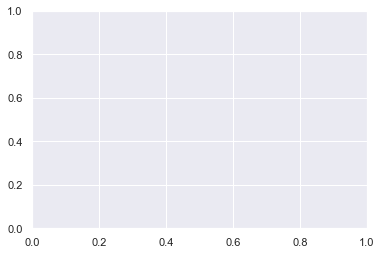

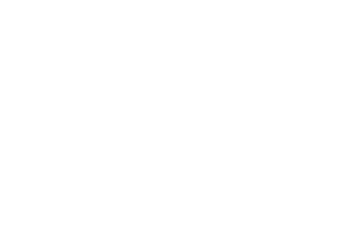

In [44]:
# Convert data into a table
table_data_1 = np.array([[accuracyScore_lin_train, accuracyScore_poly_train, accuracyScore_rbf_train], [accuracyScore_lin_test, accuracyScore_poly_test, accuracyScore_rbf_test]])
fig, ax = plt.subplots()
table_df = pd.DataFrame(table_data_1, columns=["Linear Model", "Polynomial Model", "RBF Model"])
fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')

t = ax.table(cellText=table_df.values, colWidths=[0.9]*len(table_df.columns), colLabels = table_df.columns, loc='center')
t.auto_set_font_size(False) 
t.set_fontsize(8)
fig.tight_layout()

ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.show()



In [39]:
# Create the model setting the decision function shape to one vs. one - after optimization

# Linear Kernal Function
model2_lin = SVC(kernel='linear', decision_function_shape='ovo', C=100) 
model2_lin.fit(X_train_all, y_train)
yhat2_lin_train = model2_lin.predict(X_train_all)
yhat2_lin_test = model2_lin.predict(X_test_all)

# Polynomial Kernal Function
model2_poly = SVC(kernel='poly', degree=2, decision_function_shape='ovo', C=100) 
model2_poly.fit(X_train_all, y_train)
yhat2_poly_train = model2_poly.predict(X_train_all)
yhat2_poly_test = model2_poly.predict(X_test_all)

# Radial Basis Kernal Function
model2_rbf = SVC(kernel='rbf', gamma=0.1, decision_function_shape='ovo', C=10) 
model2_rbf.fit(X_train_all, y_train)
yhat2_rbf_train = model2_rbf.predict(X_train_all)
yhat2_rbf_test = model2_rbf.predict(X_test_all)


# Calculate the accuracy scores for the training and test sets using the sklearn metrics accuracy score function
print("Linear Kernal Function")
accuracyScore_lin_train_2 = accuracy_score(y_train, yhat2_lin_train)
print("Training Accuracy Score:", accuracyScore_lin_train_2)

accuracyScore_lin_test_2 = accuracy_score(y_test, yhat2_lin_test)
print("Testing Accuracy Score:", accuracyScore_lin_test_2)
print()

print("Polynomial(degree = 2) Kernal Function")
accuracyScore_poly_train_2 = accuracy_score(y_train, yhat2_poly_train)
print("Training Accuracy Score:", accuracyScore_poly_train_2)

accuracyScore_poly_test_2 = accuracy_score(y_test, yhat2_poly_test)
print("Testing Accuracy Score:", accuracyScore_poly_test_2)
print()

print("Radial Basis Kernal Function")
accuracyScore_rbf_train_2 = accuracy_score(y_train, yhat2_rbf_train)
print("Training Accuracy Score:", accuracyScore_rbf_train_2)

accuracyScore_rbf_test_2 = accuracy_score(y_test, yhat2_rbf_test)
print("Testing Accuracy Score:", accuracyScore_rbf_test_2)
print()

C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shubh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear Kernal Function
Training Accuracy Score: 0.8848514211886305
Testing Accuracy Score: 0.8977556109725686

Polynomial(degree = 2) Kernal Function
Training Accuracy Score: 0.9025759043927648
Testing Accuracy Score: 0.9022443890274314

Radial Basis Kernal Function
Training Accuracy Score: 0.9244589793281653
Testing Accuracy Score: 0.887281795511222



# Conduct PCA Dimensional Reduction

It is possible that these 19 features are highly correlated to each other. Therefore, doing a dimension reduction with the PCA method will help eliminate/reduce the large number of correleated features into fewer independent features. In addition, reducing the 19 dimensions into 2-3 dimensions will help us visualize the data and see which hyperplane will be best to seperate the data. 

Using technique from: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [ ]:
# Initialize the Z-scored data into the PCA object
# The z-scored data must be passed into the PCA object, since if not, the first principal component will point to the mean and variables with unequal variance won't contribute to the Eigensum 

# Attempt #1
# pca = PCA(n_components = 3)
# principalComponents = pca.fit_transform(X_train_all)
# principalDf = pd.DataFrame(data=principalComponents, columns = ['principal component 1', 'principal component 2','principal component 3'])

# Attempt #2
pca = PCA().fit(X_train_all)
eigVals = pca.explained_variance_
loadings = pca.components_
rotatedData = pca.fit_transform(X_train_all)
varExplained = eigVals/sum(eigVals)*100

# for ii in range(len(varExplained)):
#     print(varExplained[ii].round(3))
    
numFactors = len(X_train_all)
x = np.linspace(1, numFactors, numFactors)
plt.bar(x, eigVals, color='gray')
plt.plot([0,numFactors,], [1,1], color='orange')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()

In [ ]:
principalDf

In [ ]:
# Convert principalDf to a numPy array
principalDf_arr = principalDf.to_numpy()

In [ ]:
# Plot the principal components data on a scatter plot
plt.scatter(principalDf_arr[:,0], principalDf_arr[:,1], cmap='autumn')

# Create SVM Model 

Create the SVM Model and fit the training data to the model. Will use a linear, polynomial, and radial-based kernal functions to see which hyperplane fits the data the best. 

In [ ]:
# Use this function from https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html to graph the hyperplane and margins

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [ ]:
model = SVC(kernel='linear', C=1E10)
model.fit(X_train,y_train)
# plot_svc_decision_function(model)


# Plot E_in, Validation, and E_out errors

In this section, the training, validation, and test errors will be plotted to check that the model is not underfitting or overfitting the data. This will indicate whether the value of C needs to be changed for the SVM model.